<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Squash ranking</div>

This notebook aims to rank the SUPAERO squash players.

1. [Simple ATP-like ranking](#sec1)
    1. [Algorithm](#sec1-1)
    2. [Results](#sec1-2)
2. [Elo ranking](#sec2)
    1. [Algorithm](#sec2-1)
    2. [Results](#sec2-2)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment',None)

# 1. <a id="sec1"></a> Simple ATP-like ranking

In this section, the players are ranked using a simple ATP-like method. For each set won by a player, he increases his ranking with $x$ point, $x$ depending on the ranking of the opponent. The function that increases the score of a player is the following:
<div style="text-align:center">$f(n) = \frac{1}{\sqrt(n)}$</div>
where $n$ is the ranking of the opponent.

In [2]:
def f(rank):
    return 1/np.sqrt(rank)

The rank of every player is updated during each commit.

## A. <a id="sec1-1"></a> Algorithm

In [3]:
def ranking_calculation(df, f):
    
    n_players = len(df.Joueur.unique())

    ### Points de chaque match
    points = []
    for match in df.Match.unique():
        rank = list(df[df["Match"]==match]["Classement"])        
        sets = list(df[df["Match"]==match]["Scores"])
        for i in range(2):
            point = sets[i]*f(rank[1-i])
            points.append(point)                
        
    df["Points"] = points
    
    ### Calcul des stats de chaque joueur
    df_ranks = pd.DataFrame(columns={"Rang", "Joueur"})
    
    df_ranks["Joueur"] = df.Joueur.unique()
    played, wins, defeats, rate, points = [], [], [], [], []
    for player in df_ranks["Joueur"]:
        matchs_played = list(df[df["Joueur"]==player]["Match"])
        nb_played = df[df["Match"].isin(matchs_played)]["Scores"].sum()
        nb_wins = df[df["Joueur"]==player]["Scores"].sum()
        nb_defeats = nb_played - nb_wins
        
        played.append(nb_played)
        wins.append(nb_wins)
        defeats.append(nb_defeats)
        rate.append("{}%".format(int(nb_wins/nb_played*100)))
        points.append(round(df[df["Joueur"]==player]["Points"].sum(), 2))

    df_ranks["Sets joués"] = played
    df_ranks["Gagnés"] = wins
    df_ranks["Perdus"] = defeats
    df_ranks["Taux de succès"] = rate
    df_ranks["Points"] = points

    df_ranks.sort_values(by=["Points", "Taux de succès"], ascending=[False, False], inplace=True)
    
    df_ranks["Rang"] = range(1, n_players+1)
    
    return df_ranks

In [4]:
def ranking_squash(filename, f, calc_sets):
    
    df_matchs = pd.read_csv(filename, sep=';', decimal=',')
    
    if df_matchs.Classement.isna().any():
                
        df_previous_matchs = df_matchs.dropna().copy()

        df_previous_rank = ranking_calculation(df_previous_matchs, f)
        
        
        # Ajout des nouveaux joueurs
        count_new_players = len(df_matchs.Joueur.unique()) - len(df_previous_rank.Joueur.unique())
        
        if count_new_players != 0:
            print("There are {} new players".format(count_new_players))
            for player in df_matchs.Joueur.unique():
                if player not in df_previous_rank.Joueur.unique():
                    new_player = [player, len(df_previous_rank.Joueur.unique())+1] + [0]*(len(df_previous_rank.columns) - 2)
                    row = pd.Series(new_player, index=df_previous_rank.columns)
                    df_previous_rank = df_previous_rank.append(row, ignore_index=True)
                    
        # Remplissage avec les nouveaux classements
        for i in range(df_matchs.shape[0]):
            if np.isnan(df_matchs["Classement"][i]):
                player = df_matchs["Joueur"][i]
                previous_rank = int(df_previous_rank[df_previous_rank["Joueur"]==player]["Rang"])
                df_matchs["Classement"][i] = previous_rank

        # Export de l'historique mis à jour
        df_matchs.to_csv(filename, sep=';', decimal=',', columns=["Match", "Joueur", "Classement", "Scores"], index=False)
    
    # Classement final
    df_rank = ranking_calculation(df_matchs, f)
    
    return df_rank

## B. <a id="sec1-2"></a> Results

In [7]:
rank = ranking_squash("Historique.csv", f, True)
rank

,Joueur,Rang,Sets joués,Gagnés,Perdus,Taux de succès,Points
3,KRa,1,87,76,11,87%,35.16
6,Mateos,2,78,28,50,35%,15.54
1,Colas,3,27,21,6,77%,10.32
0,Marin,4,35,14,21,40%,6.72
5,Gessien,5,23,12,11,52%,6.00
2,LL,6,38,13,25,34%,5.51
4,Sutter,7,37,9,28,24%,4.44
7,PLN,8,30,4,26,13%,2.50
8,Toujouse,9,11,6,5,54%,2.45
10,Alice,10,8,5,3,62%,1.58


The following table shows the points that a player can win while beating another player.

In [6]:
df_points = pd.DataFrame(columns={"Joueur", "Points à gagner (sur un set)"})
df_points["Joueur"] = rank.Joueur
n_players = len(list(df_points["Joueur"]))
df_points["Points à gagner (sur un set)"] = [round(f(i),2) for i in range(1, n_players + 1)]

df_points

,Joueur,Points à gagner (sur un set)
3,KRa,1.00
6,Mateos,0.71
1,Colas,0.58
0,Marin,0.50
5,Gessien,0.45
2,LL,0.41
4,Sutter,0.38
7,PLN,0.35
8,Toujouse,0.33
10,Alice,0.32


# 2. <a id="sec2"></a> Elo ranking

The Elo method awards points to a player according its chronological results. If he realizes a better performance than its estimated level, he will earn Elo points. Reciprocally, if he loses against a weaker opponent, he will lose some Elo points.

The calculation method is the following:

<div style="text-align:center">$E_{n+1} = E_n + K[W - p(D)]$</div>

where:
$E_n$ is the number of Elo points at time $n$, $K$ is the development factor, $W$ is the result of the game: 1 for a win and 0 for a defeat and $p(D)$ is the probability of winning depending on the difference of points between the two players and is calculated by $p(D) = \frac{1}{1+10^{\frac{-D}{200}}}$. Note that if $D$ is greater than 200, it will be reduced to 400.

Every new player will begin with a ranking of 1000 Elo points. During his first 30 sets, a player will have a high development factor $K=40$ in order to make its ranking rapidly converge to its real level. After that, the development factor will be set to 20. For players having a ranking above 2000 points, the development factor will be reduced to 10.

## A. <a id="sec2-1"></a> Algorithm

In [224]:
df_stats = pd.read_csv("Classement Elo.csv", sep=';', decimal=',')
df_stats

,Joueur,Rang,Sets joués,Gagnés,Taux de succès,Développement,Points
0,Colas,1,0,0,0,40,1000


In [225]:
evolutions = []

In [226]:
def proba(D):
    return 1/(1+pow(10,-D/200))

In [227]:
def add_points(ids, result):
    
    # Get players scores
    points = []
    for i in ids:
        points.append(df_stats["Points"][i])
    
    # Get points difference and proba
    D = points[0] - points[1]
    if abs(D) > 200:
        D = np.sign(D)*200
        
    p_D = proba(D)
    
    evolution = result[0]*(1-proba(D)) + result[1]*(-proba(D))
    evolutions.append(evolution)
    
    
    for i in range(2):
        # Player id
        id = ids[i]
        
        # Update score
        df_stats["Points"][id] += df_stats["Développement"][id]*(-2*i + 1)*evolution
        history[df_stats.Joueur[id]].append(df_stats["Points"][id])
        
        # Update number of won sets
        df_stats["Gagnés"][id] += result[i]
        
        # Update number of played sets
        df_stats["Sets joués"][id] += sum(result)
        
        # Update the success rate
        df_stats["Taux de succès"][id] = "{}%".format(round(df_stats.Gagnés[id]/df_stats["Sets joués"][id]*100,1))
        
        # Update development factor
        if df_stats["Points"][id] > 1200:
            df_stats["Développement"][id] = 10
            
        if df_stats["Développement"][id] > 10:
            if df_stats["Sets joués"][id] > 29:
                df_stats["Développement"][id] = 20 

In [228]:
df = pd.read_csv("Historique Elo.csv", sep=';', decimal=',')
history = {"Colas":[1000]}

for match in df.Match.unique():
    players = list(df[df["Match"]==match]["Joueur"])
    ids = []
    
    # Ajout des joueurs dans le tableau des stats
    for player in players:
        if player not in list(df_stats.Joueur):
            df_stats = df_stats.append({'Joueur':player,
                            'Rang':0,
                            'Sets joués':0,
                            'Gagnés':0,
                            'Taux de succès':0,
                            'Développement':40,
                            'Points':1000}, ignore_index=True)
            history["{}".format(player)] = [1000]
        ids.append(list(df_stats[df_stats["Joueur"] == player].index)[0])
    
    result = list(df[df["Match"]==match]["Scores"])
    
    add_points(ids, result)
    
df_stats = df_stats.sort_values(by=["Points"], ascending=False)
df_stats["Rang"] = range(1, len(history)+1)

In [229]:
df_stats

,Joueur,Rang,Sets joués,Gagnés,Taux de succès,Développement,Points
3,KRa,1,87,76,87.4%,20,1139
0,Colas,2,27,21,77.8%,40,1034
6,Mateos,3,78,28,35.9%,20,1028
9,Xavier,4,8,3,37.5%,40,1019
5,Gessien,5,23,12,52.2%,40,1013
10,Alice,6,8,5,62.5%,40,980
8,Toujouse,7,11,6,54.5%,40,970
1,Marin,8,35,14,40.0%,20,969
7,PLN,9,30,4,13.3%,20,929
2,LL,10,38,13,34.2%,20,904


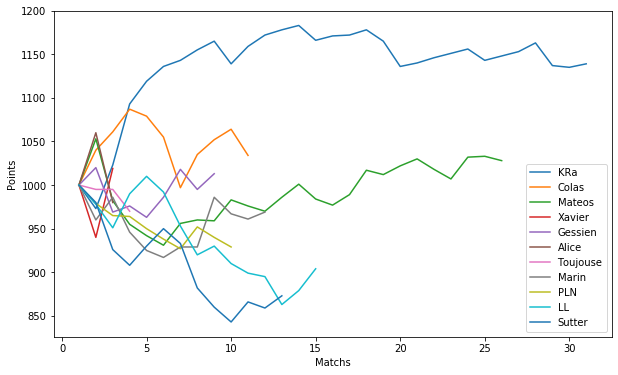

In [230]:
fig = plt.figure(figsize=(10,6))
for player in df_stats.Joueur:
    n_match = len(history[player])
    plt.plot(range(1, n_match+1), history[player], label='{}'.format(player))
    
plt.xlabel("Matchs")
plt.ylabel("Points")
plt.legend()
plt.show()

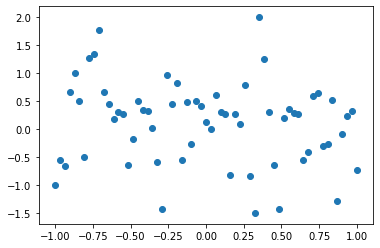

In [232]:
plt.scatter(np.linspace(-1,1,len(evolutions)),evolutions)

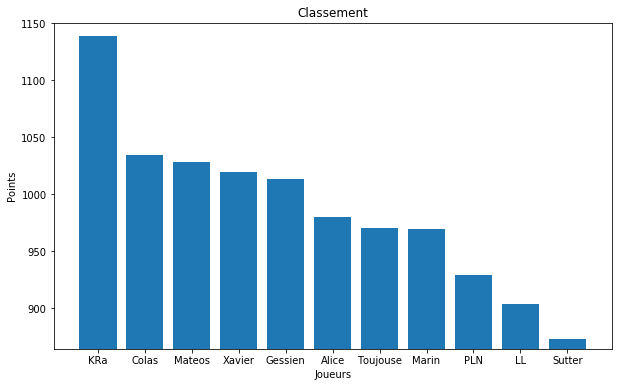

In [222]:
fig = plt.figure(figsize=(10,6))

plt.bar(list(df_stats["Joueur"]), list(df_stats["Points"]))
plt.title('Classement')
plt.xlabel('Joueurs')
plt.ylabel('Points')
plt.ylim(min(list(df_stats["Points"]))*0.99, max(list(df_stats["Points"]))*1.01)
plt.show()